## 🧠 Sleep Stage Classification from EEG Signals

In this notebook, we will explore the process of classifying sleep stages using EEG (electroencephalogram) signal data. This is a **time series classification** problem, where the objective is to identify the sleep stage from segments of EEG readings.

The dataset contains EEG recordings labeled with different sleep stages, including:

- **Wake**
- **REM (Rapid Eye Movement)**
- **Non-REM stages**: E1, E2, and E3

🎯 **Goal:**  
Develop a machine learning model capable of accurately predicting the sleep stage associated with each EEG segment.

---

We begin with **data exploration and preprocessing**, which are essential steps before training any classification model. This includes:

- Cleaning and formatting the data  
- Visualizing key patterns and distributions  
- Scaling and transforming features for optimal performance

---

After preparing the data, we will implement and compare multiple classification techniques to identify the most effective approach for this task.


# **1. Data Exploration and Visualization**


## 📦 Importing Libraries

In this section, we import all the necessary libraries required for our analysis and modeling pipeline. These are grouped by functionality for better readability:

- **Data Handling:**  
  `numpy`, `pandas`, and `math` are used for numerical computations and structured data manipulation.

- **Visualization:**  
  `matplotlib` and `seaborn` help us visualize patterns and relationships within the data.

- **Signal Processing:**  
  We use modules from `scipy.signal`, `scipy.fft`, `pywt`, and `scipy.stats` for filtering, frequency analysis, wavelet transforms, and statistical measures like skewness and kurtosis.

- **Preprocessing & Feature Selection:**  
  Includes scaling techniques (`StandardScaler`, `MinMaxScaler`, `RobustScaler`), dimensionality reduction with `PCA`, and feature selection tools such as `SelectFromModel` and `RFECV`.

- **Machine Learning Models:**  
  We utilize a range of models from `scikit-learn`, including:
  - `RandomForestClassifier`
  - `GradientBoostingClassifier`
  - `SVC` (Support Vector Classifier)
  - `MLPClassifier` (Multi-Layer Perceptron)

- **Model Utilities:**  
  Functions for train/test splitting, cross-validation, pipelines, hyperparameter tuning (`GridSearchCV`), and evaluation metrics.

- **Reproducibility:**  
  We set a global random seed using `np.random.seed(42)` to ensure consistent results across runs.

> 📌 *Warnings are also suppressed to keep the output clean and focused.*


In [83]:
# 📦 Data Handling and Basic Tools
import numpy as np
import pandas as pd
import math
import warnings
warnings.filterwarnings('ignore')

# 📊 Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 🧪 Signal Processing
from scipy import signal
from scipy.fft import fft
from scipy.signal import butter, filtfilt, welch
import pywt
from scipy.stats import skew, kurtosis

# 🧹 Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, RFECV

# 🧠 Modeling
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# 🔧 Model Utilities
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 🪄 Reproducibility
np.random.seed(42)


## 📄 Loading and Renaming Dataset

We begin by loading the sleep EEG training dataset from a CSV file using **Pandas**. The first column in the dataset represents the class labels (i.e., sleep stages), but it appears to be unnamed or labeled as `0`. We rename it to `'class'` for clarity and better code readability in the upcoming analysis steps.


In [84]:
df = pd.read_csv('Sleep Train 5000.csv')
df.rename(columns={0: 'class'}, inplace=True)

## 🔍 Previewing the Dataset

Let's take a first look at the structure of our dataset. This step helps us understand the format, column names, and the type of data we're dealing with. We display the first few rows using `df.head()`.


In [85]:
df.head()

,0,-1.6083028,-13.170696,-8.997802,1.347497,5.259585,-1.5213675,2.6515262,4.6510377,3.7816849,...,-8.041514,-6.5636144.1,-4.998779.1,-5.34652.1,-6.389744,-11.171185,-2.3907204,1.0866911,6.9113555,6.1289377
0,0,-2.825397,2.390720,3.955555,-4.216361,2.477656,2.129914,3.955555,-5.172649,5.694261,...,4.129426,7.085226,-2.390720,-2.303785,-3.694750,4.564103,-6.215873,-2.738462,-4.477167,-4.390232
1,0,-15.952625,-3.347008,-15.517949,-9.432479,-16.474237,-6.650549,-14.909402,-12.214408,-10.823443,...,-4.390232,-0.738950,4.477167,12.996825,21.951160,21.081806,21.603418,14.909402,9.345543,6.998291
2,0,-26.558731,-18.560684,-12.040537,-4.216361,-9.432479,1.260562,-2.216850,-3.520879,-5.781197,...,-3.086203,-0.652015,3.607814,15.170208,16.039560,6.128938,3.955555,-1.956044,-2.390720,-4.651038
3,0,-5.607326,6.042003,-4.129426,-5.172649,-7.172161,-11.953602,-7.780708,-0.130403,-2.912332,...,-1.260562,1.608303,4.564103,-4.911844,10.301831,10.127961,8.389256,-2.216850,-4.390232,0.478144
4,0,-10.127961,-13.344566,0.652015,6.215873,1.086691,8.736997,5.172649,-1.695238,1.086691,...,-3.086203,-5.868132,0.130403,5.694261,5.694261,5.520391,2.477656,-10.041026,-8.215385,-3.868620


## 🧮 Dataset Dimensions

We use `df.shape` to check the dimensions of our dataset. This tells us the number of samples (rows) and features (columns) present, which is useful for understanding the scale of our data.


In [86]:
df.shape

(4998, 179)

> The dataset contains EEG signal recordings collected during a sleep study. Each instance is labeled with a class ranging from 0 to 4, representing different sleep stages. The training set includes approximately 5,000 samples, each described by 178 features extracted from time series data.


In [87]:
df.iloc[:,0].value_counts()

0
2    2000
3    1040
4     751
1     697
0     510
Name: count, dtype: int64

> There is a noticeable class imbalance in the dataset. Ignoring this imbalance could significantly degrade the model's performance, as it may become biased toward the majority classes.


In [88]:
df.isnull().sum().sum()

np.int64(0)

> Next, we will visualize the data to explore potential patterns and gain insights into the distribution of features across different sleep stages.


In [89]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_time_series_of_class(df, target_class, num_series=5):
    filtered_df = df[df.iloc[:, 0] == target_class]

    # Take the first 'num_series' rows
    selected_series = filtered_df.iloc[:num_series, 1:]

    # Plot
    plt.figure(figsize=(12, 6))
    for i in range(len(selected_series)):
        plt.plot(selected_series.iloc[i], label=f'Series {i+1}')

    plt.title(f'Time Series from Class {target_class}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


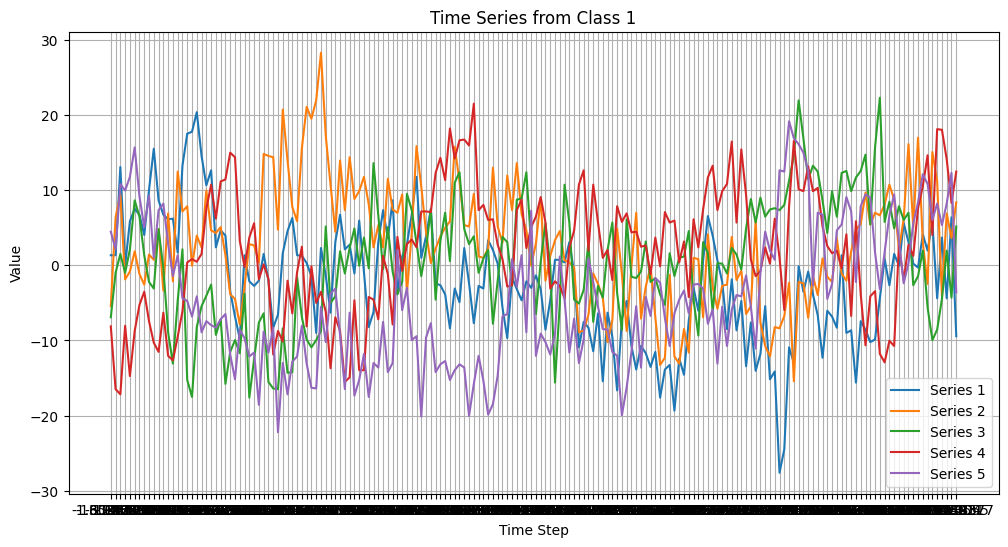

In [90]:
plot_time_series_of_class(df, target_class=1, num_series=5)


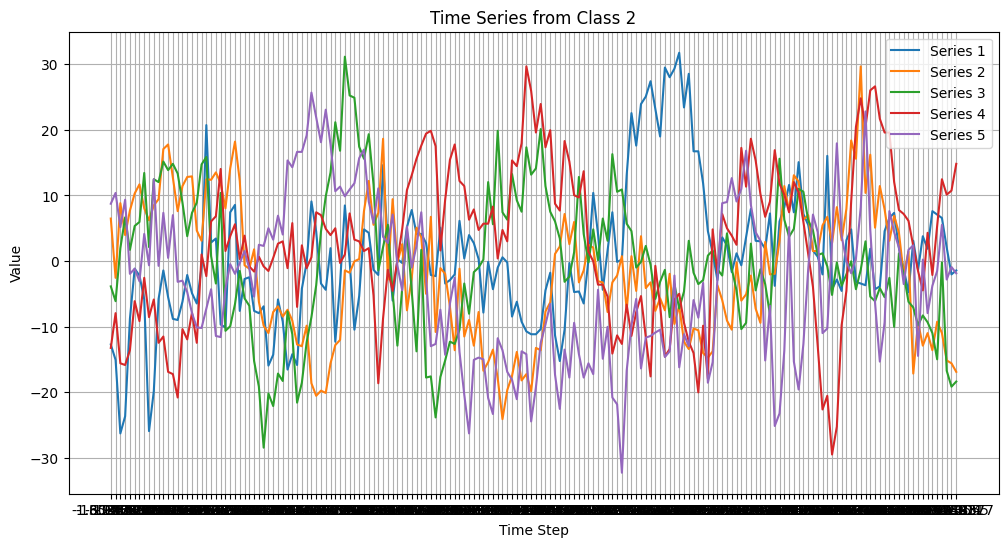

In [91]:
plot_time_series_of_class(df, target_class=2, num_series=5)


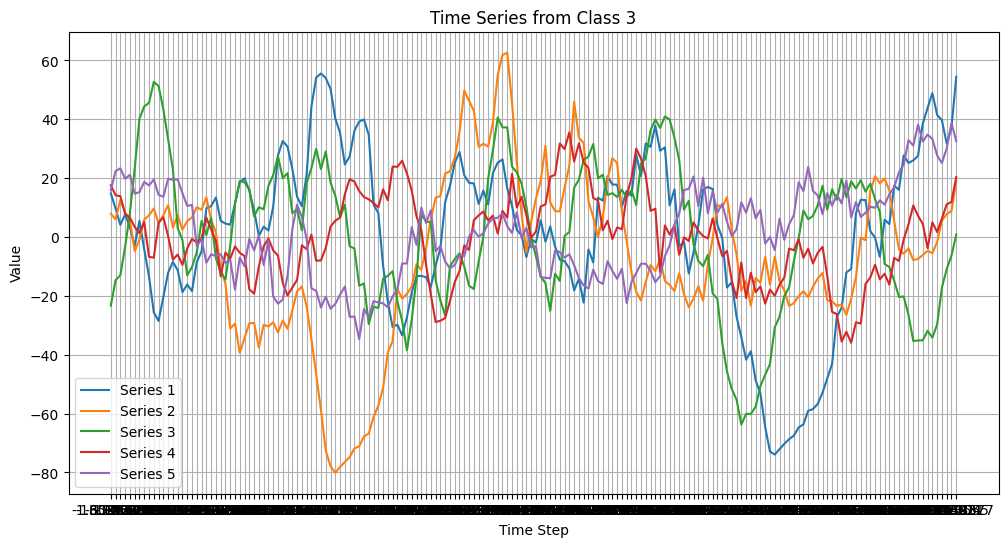

In [92]:
plot_time_series_of_class(df, target_class=3, num_series=5)


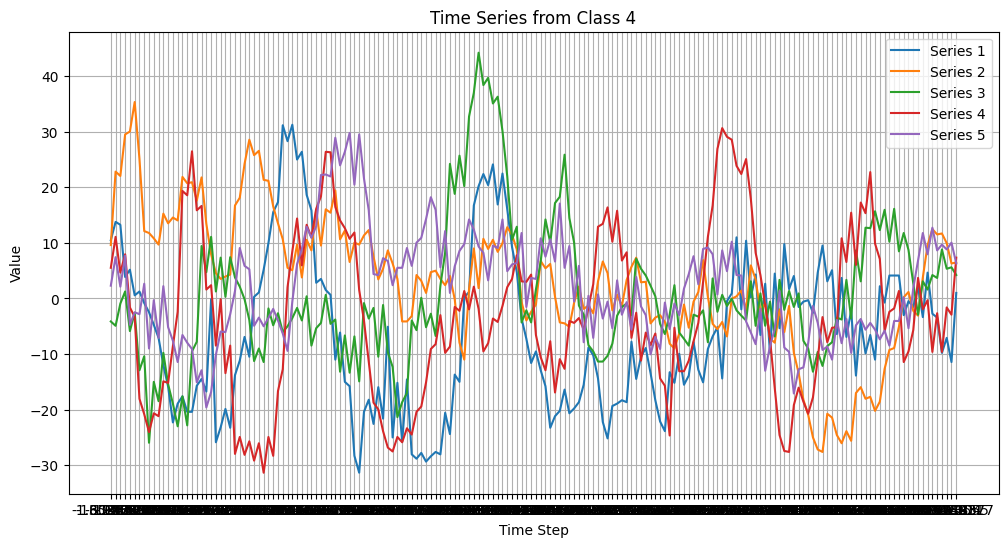

In [93]:
plot_time_series_of_class(df, target_class=4, num_series=5)


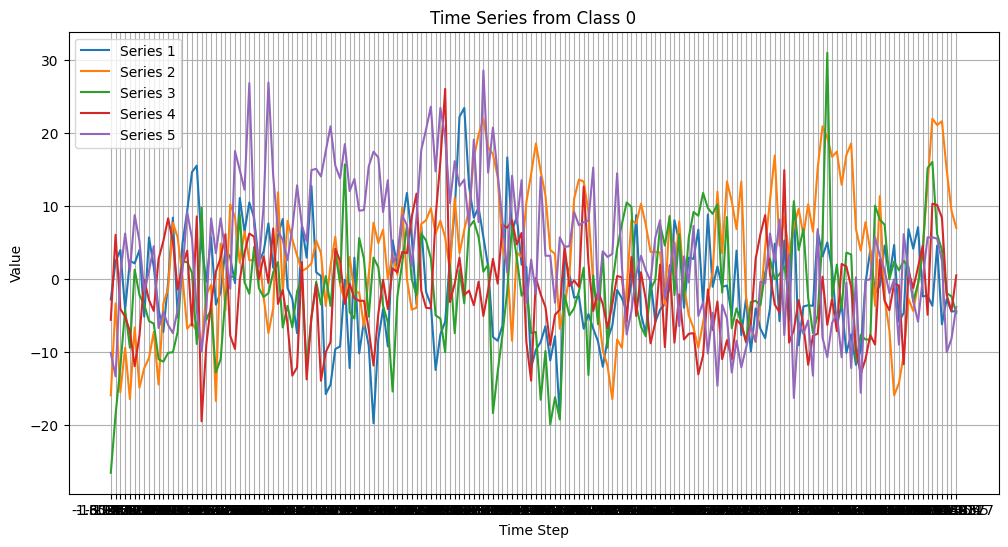

In [94]:
plot_time_series_of_class(df, target_class=0, num_series=5)


> From the plots above, it is evident that there is a noticeable distinction between classes 0 and 3. However, the differences among the remaining classes are less clear and require further analysis.


In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_time_series_all_classes(df, num_series_per_class=5):
    plt.figure(figsize=(14, 7))

    unique_classes = df.iloc[:, 0].unique()
    cmap = plt.get_cmap('tab10')

    for i, label in enumerate(unique_classes):
        class_data = df[df.iloc[:, 0] == label].iloc[:num_series_per_class, 1:]
        color = cmap(i % 10)

        for idx, row in class_data.iterrows():
            plt.plot(row.values, color=color, alpha=0.8, label=f'Class {label}' if idx == class_data.index[0] else "")

    plt.title(f'Time Series (First {num_series_per_class} per Class)')
    plt.xlabel('Time Step')
    plt.ylabel('Signal Value')
    plt.legend(title="Class", loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


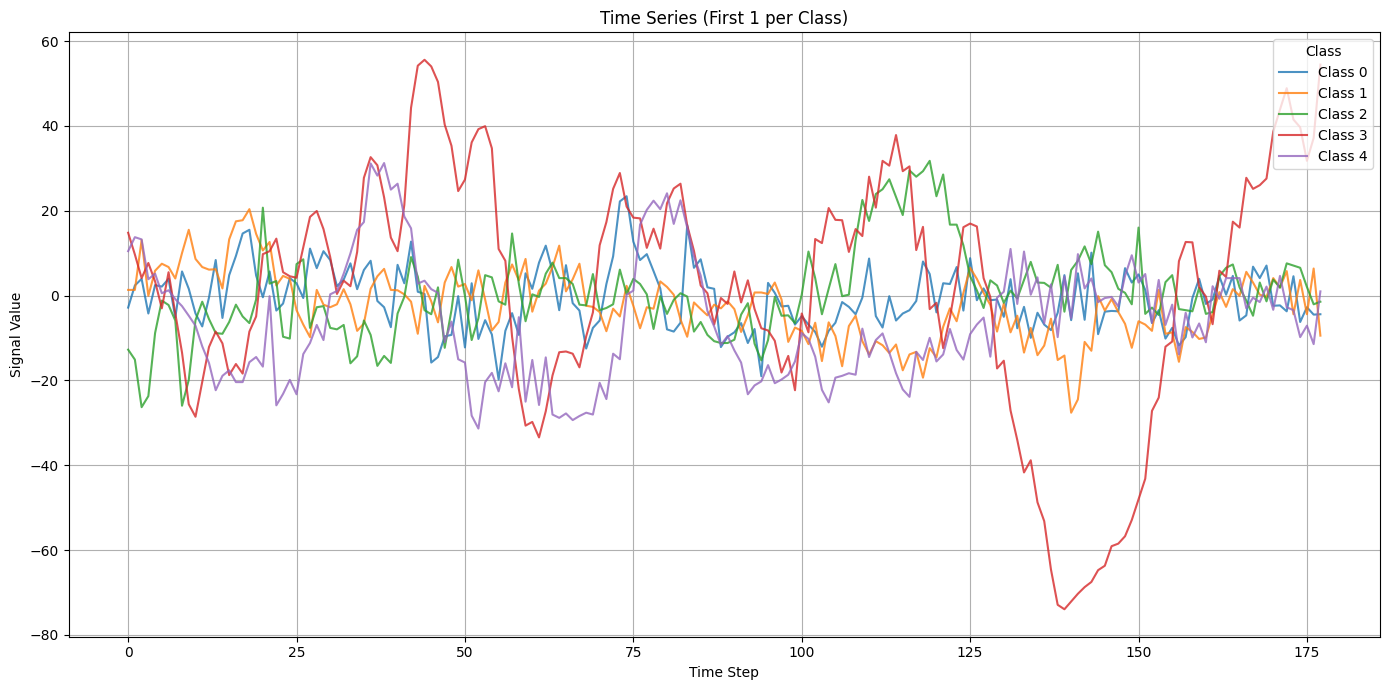

In [96]:
plot_time_series_all_classes(df, num_series_per_class=1)


> Now, we will plot the Power Spectral Density (PSD) of the EEG time series signals for each sleep stage class.  
> This visualization helps us examine the frequency bands of brain activity (such as delta, theta, etc.) and compare their characteristics across different classes.


In [97]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch

def plot_psd_by_class(df, sampling_rate=100, samples_per_class=3):
    """
    Plots the Power Spectral Density (PSD) for samples of each class in the DataFrame.

    Parameters:
    - df: pd.DataFrame, first column is class label, rest are time series values
    - sampling_rate: int, sampling frequency of the time series
    - samples_per_class: int, number of time series to plot per class
    """
    labels = sorted(df.iloc[:, 0].unique())

    freq_bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 13),
        'Beta': (13, 30),
        'Gamma': (30, 50)
    }
    band_colors = ['skyblue', 'palegreen', 'mistyrose', 'wheat', 'thistle']

    plt.figure(figsize=(15, 10))

    for i, label in enumerate(labels):
        class_data = df[df.iloc[:, 0] == label].iloc[:samples_per_class, 1:]

        for j, row in enumerate(class_data.values):
            freqs, psd = welch(row, fs=sampling_rate, nperseg=128)

            ax = plt.subplot(len(labels), samples_per_class, i * samples_per_class + j + 1)
            ax.semilogy(freqs, psd, color='black')

            for (band_name, (f_low, f_high)), color in zip(freq_bands.items(), band_colors):
                ax.axvspan(f_low, f_high, alpha=0.3, color=color)

            ax.set_title(f"Label {label} - Sample {j + 1}")
            if i == len(labels) - 1:
                ax.set_xlabel("Frequency (Hz)")
            if j == 0:
                ax.set_ylabel(f"Label {label}\nPSD (V²/Hz)")
            if i == 0 and j == 0:
                legend_handles = [plt.Rectangle((0,0),1,1,fc=c, alpha=0.3) for c in band_colors]
                ax.legend(legend_handles, freq_bands.keys(), loc='upper right', fontsize='small')

            ax.grid(True)
            ax.set_xlim(0, 50)

    plt.tight_layout()
    plt.show()


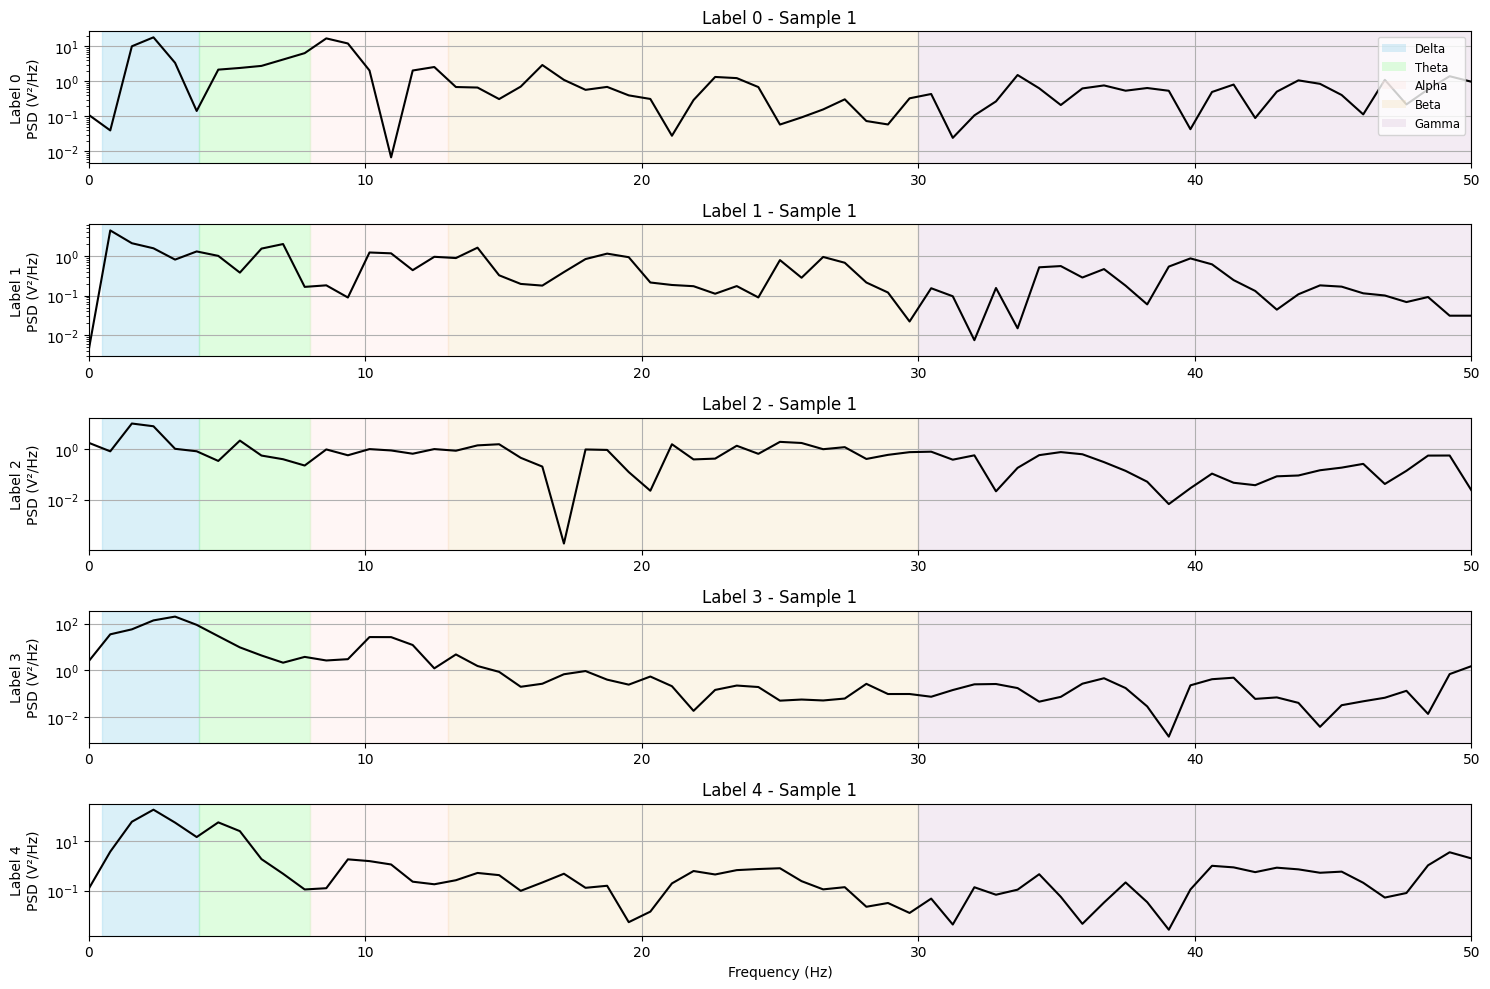

In [98]:
plot_psd_by_class(df, sampling_rate=100, samples_per_class=1)


Colored regions in the plots highlight the dominant frequency bands corresponding to well-known EEG rhythms.

The visualizations reveal a clear progression in spectral power, shifting from lower to higher frequency bands as the class label increases from 0 to 4. This pattern suggests a hierarchical model of cognitive states, where class 0 represents restful states and class 4 corresponds to an alert, engaged condition.

From these observations, we conclude that incorporating frequency-based features into our classifier is essential for accurately distinguishing sleep stages:

- Delta power serves as a strong indicator for deep sleep (E3).
- Theta band activity is prominent in REM and lighter sleep stages (E1, E2).
- Alpha and beta frequencies help differentiate Wake and REM stages from non-REM sleep.


In [99]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf

def plot_average_acf_pacf(df, class_label, max_lags=40):
    class_data = df[df.iloc[:, 0] == class_label].iloc[:, 1:].values

    acfs = []
    pacfs = []
    for series in class_data:
        acfs.append(acf(series, nlags=max_lags, fft=False))
        pacfs.append(pacf(series, nlags=max_lags, method='ywm'))

    mean_acf = np.mean(acfs, axis=0)
    mean_pacf = np.mean(pacfs, axis=0)

    lags = np.arange(len(mean_acf))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.stem(lags, mean_acf)
    plt.title(f'Average ACF - Class {class_label}')
    plt.xlabel('Lag')
    plt.ylabel('ACF')

    plt.subplot(1, 2, 2)
    plt.stem(lags, mean_pacf)
    plt.title(f'Average PACF - Class {class_label}')
    plt.xlabel('Lag')
    plt.ylabel('PACF')

    plt.tight_layout()
    plt.show()


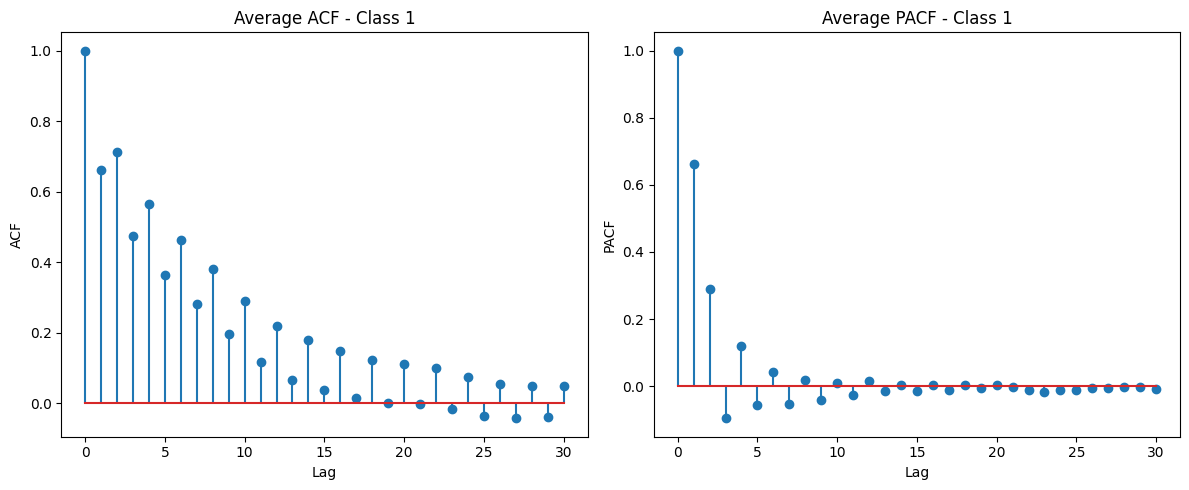

In [100]:
plot_average_acf_pacf(df, class_label=1, max_lags=30)


> EEG signals in this category display short-term dependencies, as evidenced by the gradual decline, indicating an underlying pattern or trend.

> The Partial Autocorrelation Function (PACF) drops sharply after the first and second lags, providing strong evidence that the EEG follows an AR(1) or AR(2) model.

This means that the most important information for forecasting the signal is contained in the immediately preceding values.


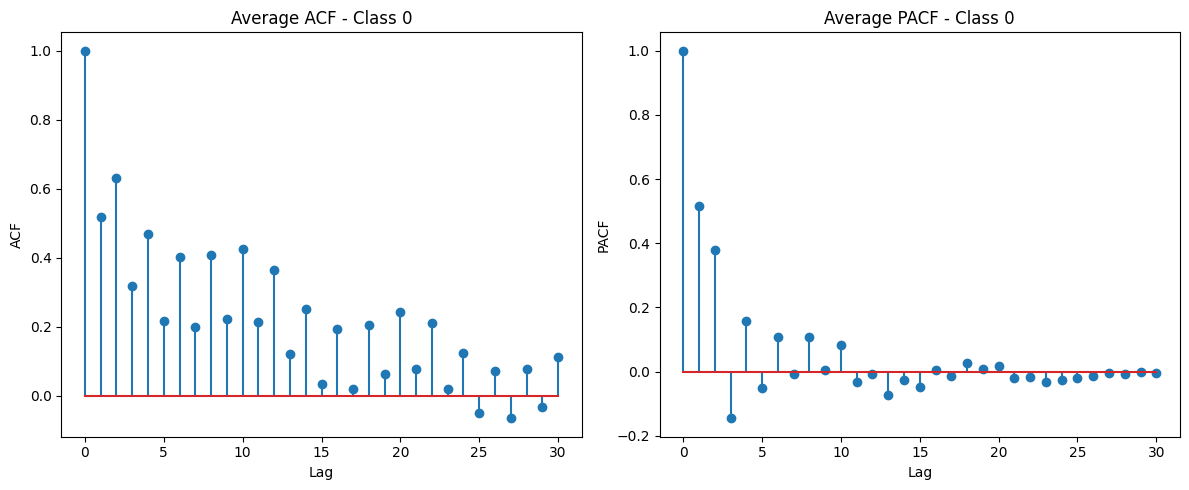

In [101]:
plot_average_acf_pacf(df, class_label=0, max_lags=30)


> The Autocorrelation Function (ACF) demonstrates a gradual decay but reveals stronger correlations at higher lags (lags 8 to 15), suggesting the presence of a temporal pattern.

> The Partial Autocorrelation Function (PACF) remains significant across several higher lags, indicating the possible presence of an autoregressive model of approximately order 5.


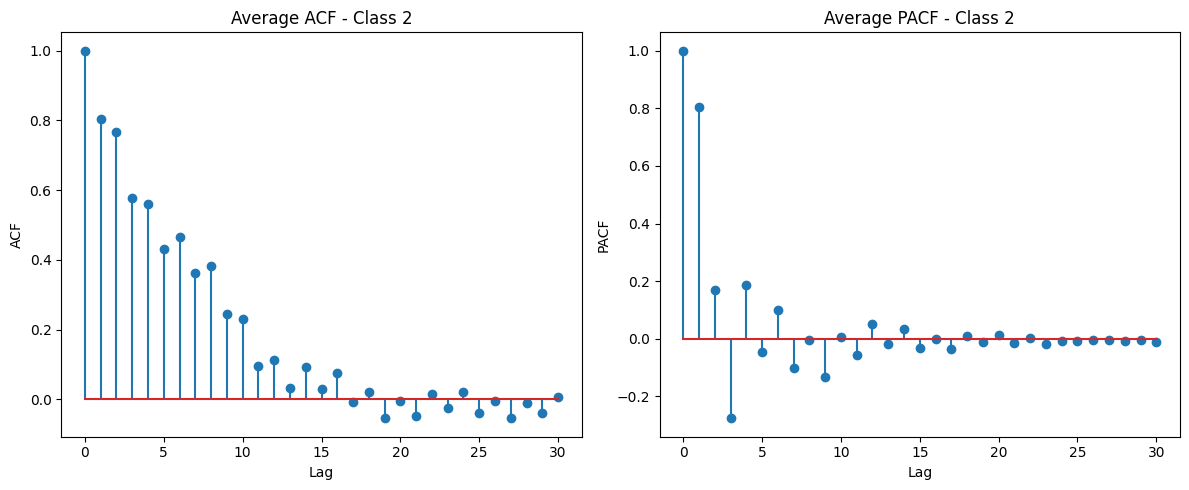

In [102]:
plot_average_acf_pacf(df, class_label=2, max_lags=30)


> The Autocorrelation Function (ACF) exhibits a steady decrease that diminishes after lag 10, suggesting the presence of an ARMA process.

> The Partial Autocorrelation Function (PACF) displays a pronounced peak at lag 1 and then drops off after lag 2, indicating a low-order autoregressive process.


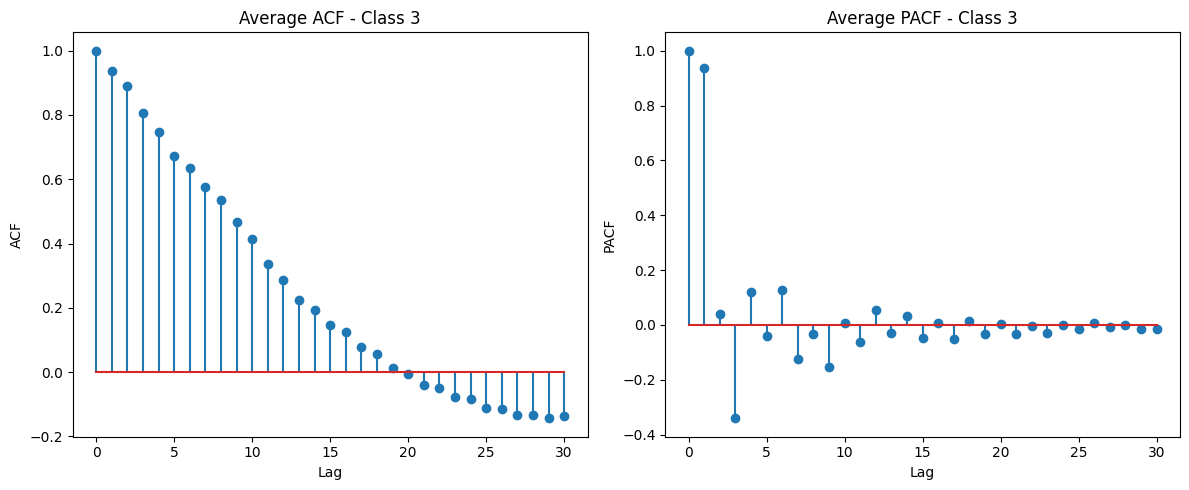

In [103]:
plot_average_acf_pacf(df, class_label=3, max_lags=30)


> The Autocorrelation Function (ACF) displays a more pronounced decay than the previous class, with positive autocorrelations persisting up to lag 20, suggesting a potential non-stationary trend.

> The Partial Autocorrelation Function (PACF) features a sharp spike at lag 1 and quickly diminishes after lag 2, pointing to a low-order autoregressive process.


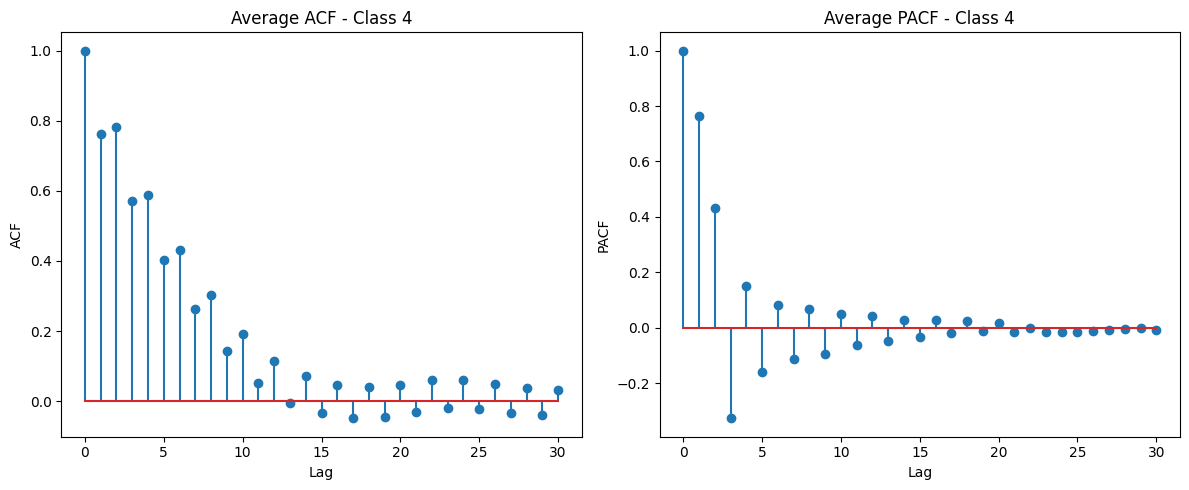

In [104]:
plot_average_acf_pacf(df, class_label=4, max_lags=30)


> The ACF shows similar behavior to the previous class

> The PACF dies off after lag 5



# **2. Feature Extraction**

## Feature Extraction Overview

We begin by calculating fundamental statistical descriptors of the EEG signals:

- **Mean, standard deviation, minimum, and maximum values**  
- **Range (difference between maximum and minimum values)**  
- **Signal energy (sum of squared amplitudes)**  
- **Number of sign changes to capture signal variability**

Additionally, other statistical measures are computed to better characterize the signals.

## Autoregressive Model Features

An autoregressive (AR) model of order 4 is fitted to each signal, from which the AR coefficients and residual variance are extracted as features.

## Frequency-Domain Features

We compute the absolute and relative power within standard EEG frequency bands:  
- Delta (0.5–4 Hz)  
- Theta (4–8 Hz)  
- Alpha (8–12 Hz)  
- Sigma (12–15 Hz)  
- Beta (15–30 Hz)

These frequency-domain metrics help capture the underlying brain activity patterns relevant for sleep stage classification.


In [105]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import welch, hilbert, find_peaks
from statsmodels.tsa.ar_model import AutoReg

try:
    from antropy import sample_entropy, higuchi_fd
except ImportError:
    sample_entropy = None
    higuchi_fd = None

BANDS = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'sigma': (12, 15),
    'beta': (15, 30)
}

def hjorth_parameters(x):
    activity = np.var(x)
    diff1 = np.diff(x)
    mobility = np.sqrt(np.var(diff1) / activity) if activity > 0 else 0
    diff2 = np.diff(diff1)
    mobility2 = np.sqrt(np.var(diff2) / np.var(diff1)) if np.var(diff1) > 0 else 0
    complexity = mobility2 / mobility if mobility > 0 else 0
    return activity, mobility, complexity

def extract_all_features(df, fs=100.0, ar_order=4):
    results = []

    for _, row in df.iterrows():
        target = row.iloc[0]
        x = row.iloc[1:].astype(float).values
        feats = {'target': target}

        # --- Basic Statistical Features ---
        feats['max_min_diff'] = np.max(x) - np.min(x)
        feats['mean'] = np.mean(x)
        feats['std'] = np.std(x)
        feats['min'] = np.min(x)
        feats['max'] = np.max(x)

        # --- Advanced Statistical Features ---
        feats['skew'] = skew(x)
        feats['kurtosis'] = kurtosis(x)
        feats['energy'] = np.sum(x ** 2)
        feats['sign_changes'] = np.mean(np.diff(np.sign(x)))

        if np.std(x) == 0:
            feats['entropy'] = 0
            feats['autocorr'] = 0
        else:
            norm_x = x / (np.linalg.norm(x) + 1e-10)
            feats['entropy'] = -np.sum(norm_x * np.log(np.abs(norm_x) + 1e-10))
            feats['autocorr'] = np.corrcoef(x[:-1], x[1:])[0, 1]

        peaks, _ = find_peaks(x)
        feats['num_peaks'] = len(peaks)
        feats['trend'] = np.polyfit(np.arange(len(x)), x, 1)[0]

        # --- Hjorth Parameters ---
        hj_activity, hj_mobility, hj_complexity = hjorth_parameters(x)
        feats['hjorth_activity'] = hj_activity
        feats['hjorth_mobility'] = hj_mobility
        feats['hjorth_complexity'] = hj_complexity

        # --- Line length ---
        feats['line_length'] = np.sum(np.abs(np.diff(x)))

        # --- AR coefficients ---
        try:
            ar_model = AutoReg(x, lags=ar_order, old_names=False).fit()
            for i, coef in enumerate(ar_model.params[1:], start=1):
                feats[f'ar_coef_{i}'] = coef
            feats['ar_resid_var'] = np.var(ar_model.resid)
        except Exception:
            for i in range(1, ar_order + 1):
                feats[f'ar_coef_{i}'] = 0
            feats['ar_resid_var'] = 0

        # --- Frequency domain ---
        f, Pxx = welch(x, fs=fs, nperseg=int(fs*2))
        total_power = np.trapz(Pxx, f)
        for band, (f_low, f_high) in BANDS.items():
            mask = (f >= f_low) & (f <= f_high)
            band_power = np.trapz(Pxx[mask], f[mask])
            feats[f'pow_{band}'] = band_power
            feats[f'ratio_{band}'] = band_power / total_power if total_power > 0 else 0
        feats['spectral_entropy'] = -np.sum(Pxx * np.log(Pxx + 1e-12))
        feats['spectral_edge_freq'] = f[np.where(np.cumsum(Pxx) >= 0.9*np.sum(Pxx))[0][0]]
        feats['dom_freq'] = f[np.argmax(Pxx)]

        # --- Hilbert envelope ---
        analytic = hilbert(x)
        envelope = np.abs(analytic)
        feats['envelope_mean'] = np.mean(envelope)
        feats['envelope_std'] = np.std(envelope)

        # --- Nonlinear features ---
        feats['sample_entropy'] = sample_entropy(x) if sample_entropy else np.nan
        feats['higuchi_fd'] = higuchi_fd(x) if higuchi_fd else np.nan

        results.append(feats)

    return pd.DataFrame(results)


## Extracting Features

Now, we extract all the relevant features from the raw EEG dataset using the `extract_all_features` function:



In [106]:

features_df = extract_all_features(df)


In [107]:
features_df.shape

(4998, 40)

## Checking for Missing Values

Let's verify if there are any missing values in the extracted features:



In [108]:
features_df.isnull().sum()

target                   0
max_min_diff             0
mean                     0
std                      0
min                      0
max                      0
skew                     0
kurtosis                 0
energy                   0
sign_changes             0
entropy                  0
autocorr                 0
num_peaks                0
trend                    0
hjorth_activity          0
hjorth_mobility          0
hjorth_complexity        0
line_length              0
ar_coef_1                0
ar_coef_2                0
ar_coef_3                0
ar_coef_4                0
ar_resid_var             0
pow_delta                0
ratio_delta              0
pow_theta                0
ratio_theta              0
pow_alpha                0
ratio_alpha              0
pow_sigma                0
ratio_sigma              0
pow_beta                 0
ratio_beta               0
spectral_entropy         0
spectral_edge_freq       0
dom_freq                 0
envelope_mean            0
e

In [109]:
features_df.isnull().sum()

target                   0
max_min_diff             0
mean                     0
std                      0
min                      0
max                      0
skew                     0
kurtosis                 0
energy                   0
sign_changes             0
entropy                  0
autocorr                 0
num_peaks                0
trend                    0
hjorth_activity          0
hjorth_mobility          0
hjorth_complexity        0
line_length              0
ar_coef_1                0
ar_coef_2                0
ar_coef_3                0
ar_coef_4                0
ar_resid_var             0
pow_delta                0
ratio_delta              0
pow_theta                0
ratio_theta              0
pow_alpha                0
ratio_alpha              0
pow_sigma                0
ratio_sigma              0
pow_beta                 0
ratio_beta               0
spectral_entropy         0
spectral_edge_freq       0
dom_freq                 0
envelope_mean            0
e

## Removing Features with Missing Values

Since the features `sample_entropy` and `higuchi_fd` contain missing values, we will drop these columns:



In [110]:
features_df.drop(columns=['sample_entropy', 'higuchi_fd'], inplace=True)

In [111]:
features_df.columns

Index(['target', 'max_min_diff', 'mean', 'std', 'min', 'max', 'skew',
       'kurtosis', 'energy', 'sign_changes', 'entropy', 'autocorr',
       'num_peaks', 'trend', 'hjorth_activity', 'hjorth_mobility',
       'hjorth_complexity', 'line_length', 'ar_coef_1', 'ar_coef_2',
       'ar_coef_3', 'ar_coef_4', 'ar_resid_var', 'pow_delta', 'ratio_delta',
       'pow_theta', 'ratio_theta', 'pow_alpha', 'ratio_alpha', 'pow_sigma',
       'ratio_sigma', 'pow_beta', 'ratio_beta', 'spectral_entropy',
       'spectral_edge_freq', 'dom_freq', 'envelope_mean', 'envelope_std'],
      dtype='object')

In [112]:
features_df.isnull().sum()

target                0
max_min_diff          0
mean                  0
std                   0
min                   0
max                   0
skew                  0
kurtosis              0
energy                0
sign_changes          0
entropy               0
autocorr              0
num_peaks             0
trend                 0
hjorth_activity       0
hjorth_mobility       0
hjorth_complexity     0
line_length           0
ar_coef_1             0
ar_coef_2             0
ar_coef_3             0
ar_coef_4             0
ar_resid_var          0
pow_delta             0
ratio_delta           0
pow_theta             0
ratio_theta           0
pow_alpha             0
ratio_alpha           0
pow_sigma             0
ratio_sigma           0
pow_beta              0
ratio_beta            0
spectral_entropy      0
spectral_edge_freq    0
dom_freq              0
envelope_mean         0
envelope_std          0
dtype: int64

In [113]:
columns = [
    'skew', 'kurtosis', 'energy', 'entropy',
    'mean_sign_diff', 'autocorr', 'num_peaks', 'trend',
    'ptp', 'mean', 'std', 'min', 'max']

## 3. Model Training


### Using All Features in the dataset


### Gradient Boosting Classifier

We start by training a Gradient Boosting Classifier, which builds an ensemble of weak learners to improve prediction accuracy.


Classification Report:

              precision    recall  f1-score   support

         0.0       0.68      0.62      0.65       102
         1.0       0.63      0.63      0.63       140
         2.0       0.69      0.74      0.71       400
         3.0       0.82      0.79      0.81       208
         4.0       0.66      0.61      0.63       150

    accuracy                           0.70      1000
   macro avg       0.70      0.68      0.69      1000
weighted avg       0.70      0.70      0.70      1000



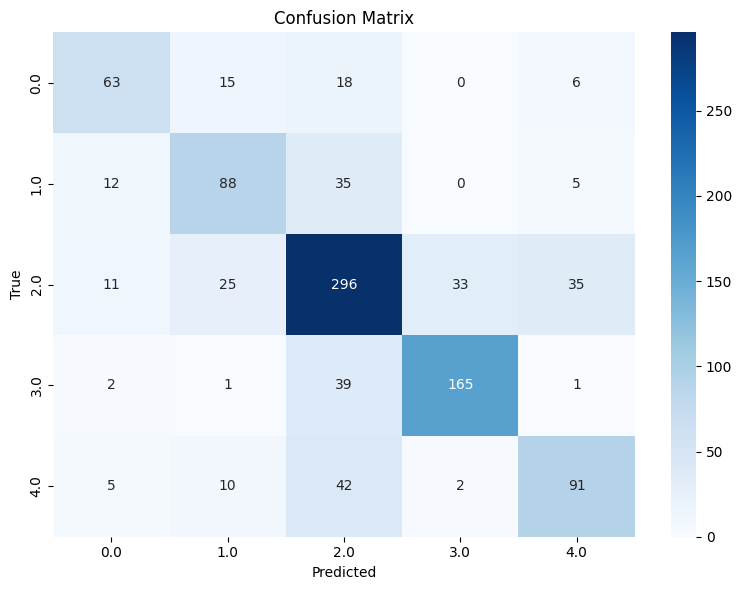

Model saved as 'gradient_boosting_pipeline.pkl'


In [116]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # for saving the model

# Split features and labels
X = features_df.iloc[:, 1:]  # all signal features
y = features_df['target']     # class labels

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define the pipeline with scaling and Gradient Boosting
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        random_state=42
    ))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = pipeline.predict(X_test)

# Evaluate performance
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Save the trained pipeline to a file
joblib.dump(pipeline, 'gradient_boosting_pipeline.pkl')
print("Model saved as 'gradient_boosting_pipeline.pkl'")


### K-Nearest Neighbors Classifier

Next, we use the K-Nearest Neighbors algorithm that classifies based on the majority vote of nearest neighbors.


Classification Report:

              precision    recall  f1-score   support

         0.0       0.59      0.59      0.59       102
         1.0       0.61      0.59      0.60       140
         2.0       0.64      0.67      0.65       400
         3.0       0.70      0.76      0.73       208
         4.0       0.60      0.51      0.55       150

    accuracy                           0.64      1000
   macro avg       0.63      0.62      0.63      1000
weighted avg       0.64      0.64      0.64      1000



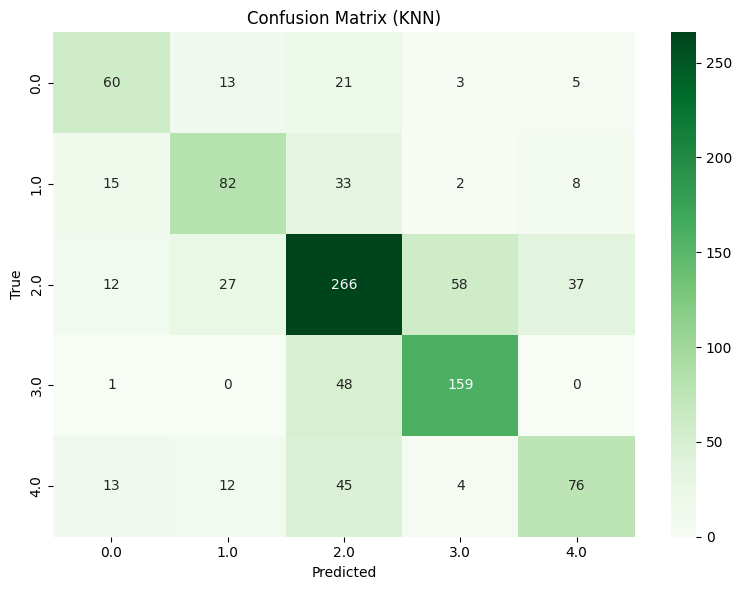

KNN model saved as 'knn_pipeline.pkl'


In [117]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # for saving the model

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (KNN)')
plt.tight_layout()
plt.show()

# Save the trained pipeline
joblib.dump(pipeline, 'knn_pipeline.pkl')
print("KNN model saved as 'knn_pipeline.pkl'")


### Voting Classifier Ensemble

Finally, we combine Gradient Boosting and Random Forest classifiers using a Voting Classifier to leverage the strengths of both models.


Voting Classifier (RF + GB):

              precision    recall  f1-score   support

         0.0       0.70      0.60      0.65       102
         1.0       0.65      0.63      0.64       140
         2.0       0.69      0.77      0.72       400
         3.0       0.84      0.79      0.82       208
         4.0       0.68      0.61      0.64       150

    accuracy                           0.71      1000
   macro avg       0.71      0.68      0.69      1000
weighted avg       0.71      0.71      0.71      1000



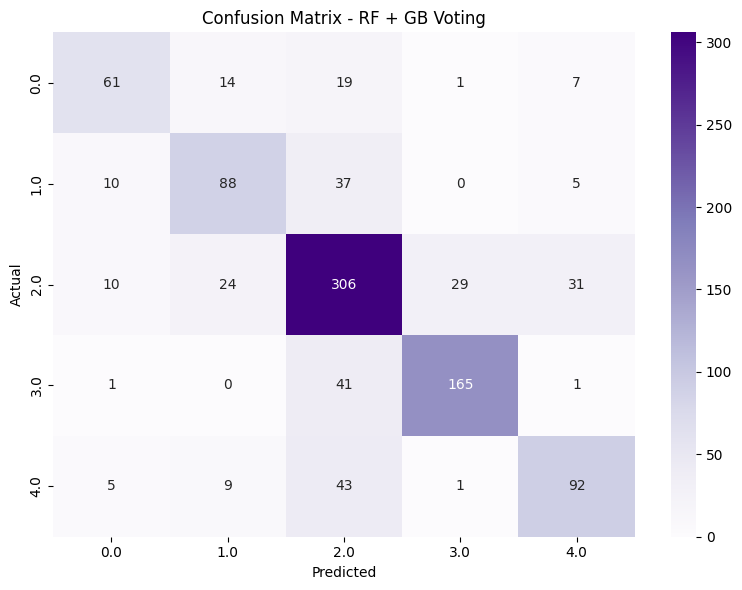

VotingClassifier model saved as 'voting_classifier_pipeline.pkl'


In [118]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # for saving the model

# Define base models
rf = RandomForestClassifier(random_state=42, max_depth=None, n_estimators=200)
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    random_state=42
)

# Combine in VotingClassifier pipeline
ensemble = Pipeline([
    ('scaler', StandardScaler()),
    ('voter', VotingClassifier(estimators=[
        ('rf', rf),
        ('gb', gb)
    ], voting='soft'))  # soft voting uses predicted probabilities
])

# Train the model
ensemble.fit(X_train, y_train)

# Predict
y_pred = ensemble.predict(X_test)

# Evaluation
print("Voting Classifier (RF + GB):\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - RF + GB Voting")
plt.tight_layout()
plt.show()

# Save the trained pipeline
joblib.dump(ensemble, 'voting_classifier_pipeline.pkl')
print("VotingClassifier model saved as 'voting_classifier_pipeline.pkl'")


### LightGBM Classifier

We use a pipeline that first scales the features using `StandardScaler` and then trains a LightGBM classifier with tuned hyperparameters. After training, we evaluate the model’s performance using a classification report and visualize the results with a confusion matrix.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8599
[LightGBM] [Info] Number of data points in the train set: 3998, number of used features: 37
[LightGBM] [Info] Start training from score -2.282282
[LightGBM] [Info] Start training from score -1.970984
[LightGBM] [Info] Start training from score -0.915791
[LightGBM] [Info] Start training from score -1.569717
[LightGBM] [Info] Start training from score -1.894955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

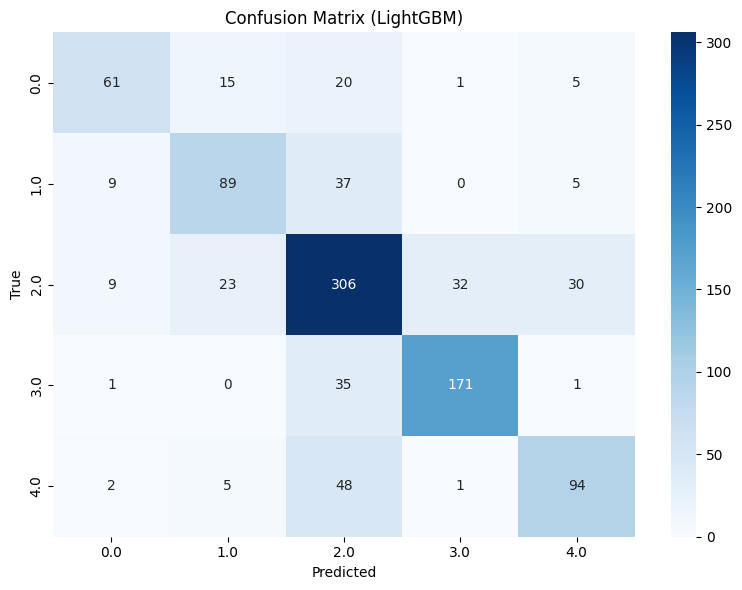

Model saved as 'lightgbm_pipeline.pkl'


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # for saving the pipeline

# Assuming X_train, X_test, y_train, y_test are already defined

# LightGBM pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lgbm', lgb.LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=8,
        num_leaves=50,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

print("LightGBM Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (LightGBM)')
plt.tight_layout()
plt.show()

# Save the trained pipeline to a file
joblib.dump(pipeline, 'lightgbm_pipeline.pkl')
print("Model saved as 'lightgbm_pipeline.pkl'")
